Validation of the Zeeman effect with gepore_zeeman.f (field out of plane)
=========================================================================

This example demonstrates the use of the gepore_zeeman.f program
(a modification of the original gepore.f published in the PNR book chapter)
to validate a model with

* strong spin-flip scattering 
* high magnetic field
* field out-of-plane (perpendicular to sample surface, but parallel to $\vec Q$)
* magnetization in-plane, therefore perpendicular to field ($\vec M \perp \vec H$)

The model is a simple slab with a single layer of magnetic material on
a non-magnetic substrate.

In [1]:
import numpy as np
from refl1d.validation.gepore_runner import GeporeRunner


start a GeporeRunner instance

In [2]:
runner = GeporeRunner()

QS = 0.001  # start value of Q
DQ = 0.0004  # step size in Q
NQ = 80  # number of Q points
Qz = np.arange(NQ) * DQ + QS


### Define the sample as a list of layers

_(note that the in-plane magnetization angle $\theta_M$ doesn't matter when the field is out-of-plane)_

| label      | thickness (A) | $\text{SLD}_N$ $(10^{-6}A)$ | $\text{SLD}_M$ $(10^{-6}A)$ | $\theta_{M}$ $(\text{degrees})$ |
|------------|---------------|-----------------------------|-----------------------------|--------------------------------|
| vacuum     | 0             | 0.0                         | 0.0                         | 90.0                           |
| magnetic   | 500           | 8.0                         | 2.0                         | 90.0                           |
| substrate  | 0             | 2.0                         | 0.0                         | 90.0                           |


In [3]:
Aguide = 0.00000001  # nearly zero to avoid division by zero in gepore.f
layers = [
    # depth rho rhoM thetaM phiM
    [0, 0.0, 0.0, 90.0, 0.0],
    [500, 8.0, 2.0, 90.0, 0.0],
    [0, 2.0, 0.0, 90.0, 0.0],
]
depth, rhoN, rhoM, thetaM, phiM = list(zip(*layers))


applied field, in Tesla:

In [4]:
H = 0.5

### Calculating with `gepore_zeeman.f`
The reflectivities are returned from `gepore_zeeman.f` in the order
$(r_g^{++}, r_g^{+-}, r_g^{-+}, r_g^{--})$

**NOTE** we use a value of $\text{EPS} = -\text{Aguide}$

In [5]:
EPS = -Aguide
rgz = runner.run(layers, QS, DQ, NQ, EPS, H, zeeman_corrections=True)
Rgz = [np.abs(r) ** 2 for r in rgz]


### Calculating reflectivity using Refl1D
magnetic_amplitude returns cross-sections in order $(r_1^{--}, r_1^{-+}, r_1^{+-}, r_1^{++})$, 
so we need to reverse them here to compare to gepore outputs

In [6]:
from refl1d.sample.reflectivity import magnetic_amplitude

r1 = magnetic_amplitude(Qz / 2, depth, rhoN, 0, rhoM, thetaM, 0, Aguide, H)
R1 = np.abs(r1[::-1]) ** 2

### Plots

In [7]:
from matplotlib import pyplot as plt

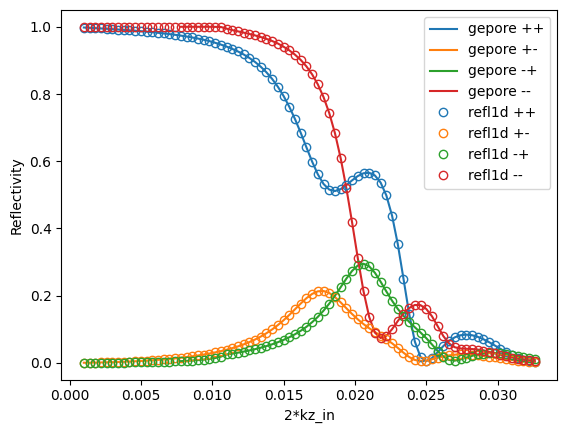

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs_labels = ["++", "+-", "-+", "--"]
for i, label in enumerate(xs_labels):
    ax.plot(Qz, Rgz[i], label=f"gepore {label}")
ax.set_prop_cycle(None)
for i, label in enumerate(xs_labels):
    ax.plot(Qz, R1[i], "o", label=f"refl1d {label}", fillstyle="none")
ax.set_ylabel("Reflectivity")
ax.set_xlabel("2*kz_in")
ax.legend()


The differences between the two reflectivity outputs are small, and are
likely due to differences in the numerical implementation of the
reflectivity calculation.  Here is a plot of the differences:

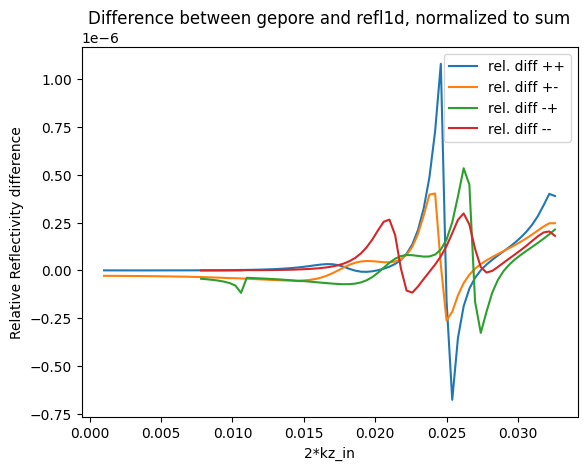

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i, label in enumerate(xs_labels):
    ax.plot(Qz, 2 * (Rgz[i] - R1[i]) / np.abs(Rgz[i] + R1[i]), label=f"rel. diff {label}")
ax.set_ylabel("Relative Reflectivity difference")
ax.set_xlabel("2*kz_in")
ax.set_title("Difference between gepore and refl1d, normalized to sum")
ax.legend()